     Wavelength        I     step
0     545.47000  0.40742  0.00005
1     545.47005  0.40693      NaN
2     545.47010  0.40797      NaN
3     545.47015  0.40833      NaN
4     545.47020  0.40894      NaN
..          ...      ...      ...
796   545.50980  0.40589      NaN
797   545.50985  0.40565      NaN
798   545.50990  0.40498      NaN
799   545.50995  0.40589      NaN
800   545.51000  0.40608      NaN

[801 rows x 3 columns]


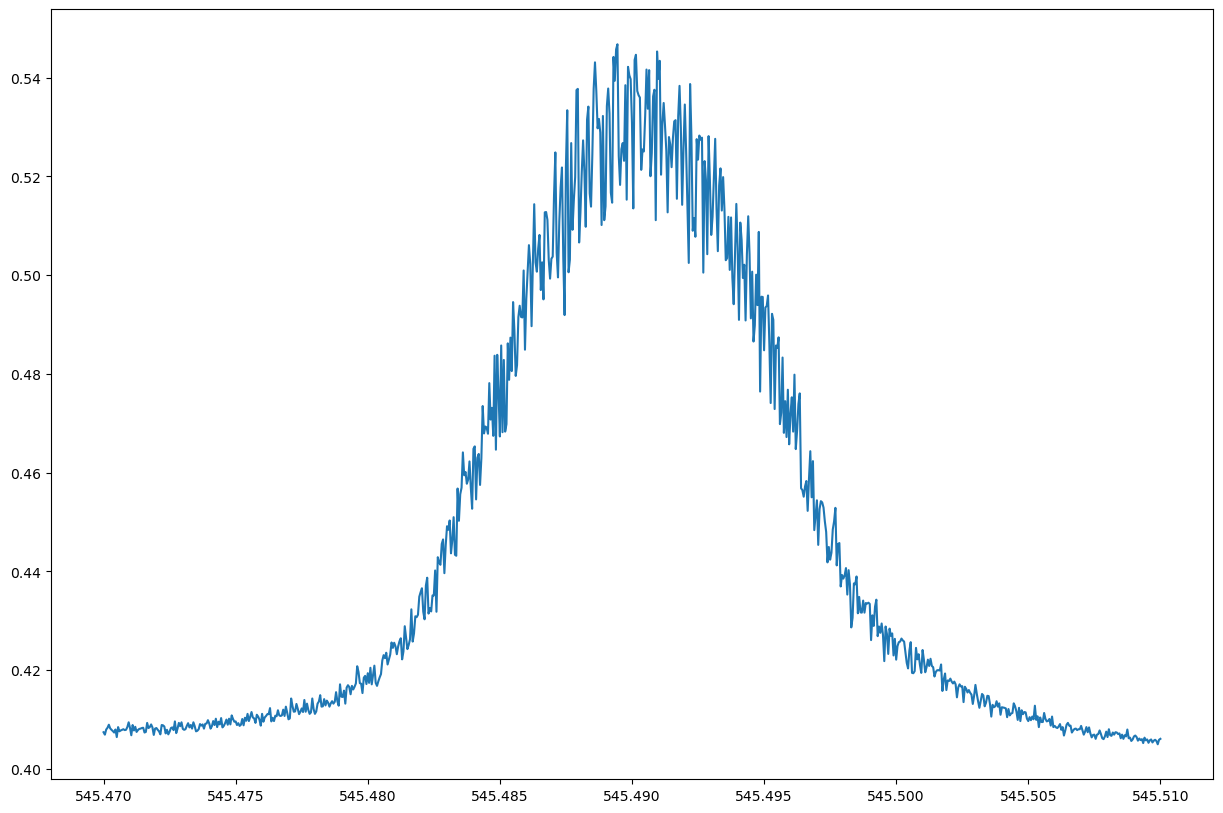

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##############
# Import data
##############

df_Hg = pd.read_csv("Hg_Spectra_Step00005_546_latest.csv") # create pandas dataframe
print(df_Hg[: 802]) # 


##############
# Plot data
##############

x_Hg = df_Hg["Wavelength"] # grab column
y_Hg = df_Hg["I"] # grab column
plt.figure(figsize=(15,10))
plt.plot(x_Hg, y_Hg)
plt.show()

# Create a train/test split
# train_split = int(0.8 * len(X))
# X_train, y_train = x_Hg[:train_split], y_Hg[:train_split]
# X_test, y_test = x_Hg[train_split:], y_Hg[train_split:]

# print(len(X_train), len(y_train), len(X_test), len(y_train))

# instantiate DataLoader
#    we use the 4 batches of 200 obervations each (full data has 100 observations)
#    we also shuffle the data
# train_dataloader = DataLoader(training_data, batch_size=, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [78]:
x_Hg = torch.tensor(x_Hg)
y_Hg = torch.tensor(y_Hg)

# Define the model
class GaussianModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a_Hg = nn.Parameter(torch.randn(1, # <- start with a random weight value
                                                requires_grad=True,
                                                dtype=torch.float))
        self.mean_Hg = nn.Parameter(torch.randn(1, # <- start with a random weight value
                                                requires_grad=True,
                                                dtype=torch.float))
        self.sigma_Hg = nn.Parameter(torch.randn(1, # <- start with a random weight value
                                                requires_grad=True,
                                                dtype=torch.float))
        self.h_Hg = nn.Parameter(torch.randn(1, # <- start with a random weight value
                                                requires_grad=True,
                                                dtype=torch.float))
    
    def forward(self, x_Hg: torch.Tensor):
        return self.a_Hg * torch.exp((-(x_Hg - self.mean_Hg)**2)/(2 * self.sigma_Hg**2)) + self.h_Hg # <- Formula for

# Create the model and optimizer
model = GaussianModel().to(device)

In [79]:
x_Hg = torch.tensor(x_Hg)
y_Hg = torch.tensor(y_Hg)


##################################################
## representing train data as a Dataset object
##################################################

class HgSpectraData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, x_Hg, y_Hg, device):
        self.x_Hg = torch.reshape(x_Hg, (len(x_Hg), 1))
        self.x_Hg = self.x_Hg.to(device)
        self.y_Hg = torch.reshape(y_Hg, (len(y_Hg), 1))
        self.y_Hg = self.y_Hg.to(device)

    def __len__(self):
        return(len(self.x_Hg))

    def __getitem__(self, idx):
        return(x_Hg[idx], y_Hg[idx])

# instantiate Dataset object for current training data
d = nonLinearRegressionData(x_Hg, y_Hg, device)

# instantiate DataLoader
#    we use the 4 batches of 200 obervations each (full data has 100 observations)
#    we also shuffle the data
train_dataloader = DataLoader(d, batch_size=200 , shuffle=True)

In [80]:
#######################
## training the model
#######################

# Define the loss function and optimizer
loss_function = nn.MSELoss()
# Setup an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
nTrainSteps = 1000

for epoch in range(0, nTrainSteps):
  # Set current loss value
  current_loss = 0.0

  # Iterate over the DataLoader for training data
  for i, data in enumerate(train_dataloader, 0):
    # Get inputs
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    # Perform forward pass (make sure to supply the input in the right way)
    outputs = model(torch.reshape(inputs, (len(inputs), 1))).squeeze()
    # Compute loss
    loss = loss_function(outputs, targets)
    # Perform backward pass
    loss.backward()
    # Perform optimization
    optimizer.step()
    # Print statistics
    current_loss += loss.item()

  if (epoch + 1) % 250 == 0:
      print('Loss after epoch %5d: %.3f' %
            (epoch + 1, current_loss))
      current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Loss after epoch   250: 2.552
Loss after epoch   500: 0.132
Loss after epoch   750: 0.011
Loss after epoch  1000: 0.011
Training process has finished.


In [81]:
print("Fit Amplitude: ", model.a_Hg.item(),
      "\n Fit Mean (Wavelength): ", model.mean_Hg.item(),
      "\n Fit Sigma (distance from mean to sides): ", model.sigma_Hg.item(),
      "\n Fit Height: ", model.h_Hg.item())

Fit Amplitude:  0.8612441420555115 
 Fit Mean (Wavelength):  1.1482517719268799 
 Fit Sigma (distance from mean to sides):  -1.2804759740829468 
 Fit Height:  0.44660407304763794


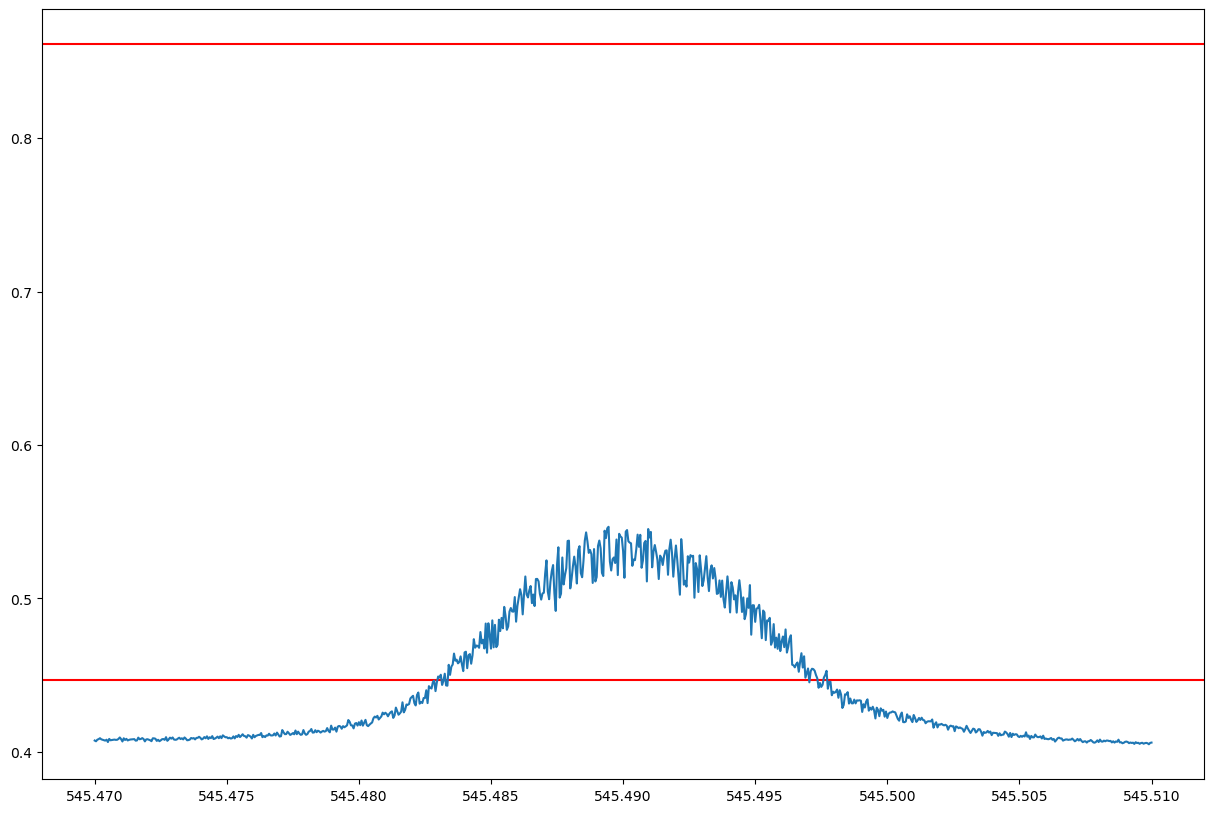

In [98]:
########
# Plot
#######

plt.figure(figsize=(15,10))
plt.axhline(y = model.a_Hg.item(), color = 'r', linestyle = '-') 
#plt.axvline(x = model.mean_Hg.item(), color = 'b', linestyle = '-') 
#plt.axvline(x = model.sigma_Hg.item(), color = 'r', linestyle = '-') 
plt.axhline(y = model.h_Hg.item(), color = 'r', linestyle = '-') 
plt.plot(x_Hg, y_Hg)
plt.show()